# Author's Notes

May 2021 Update: We now generate tab-delimited files (TSVs) for each clustering algo. You can load the first three dimensions along with the labels in [Tensorboard Projector](https://projector.tensorflow.org) to visualize  clustering in 3-D space.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 5 - Clustering

# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning


In [ ]:
# Install additional libraries
!pip3 install fastcluster==1.1.26
!pip3 install hdbscan==0.8.27

# Import Libraries

In [4]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# Load Data

In [ ]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [9]:
print(X_train.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)


In [6]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [7]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dimensionality Reduction

In [10]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [11]:
 # Log data
cwd = os.getcwd()
log_dir = cwd+"/logs/05_clustering/"
y_train[0:2000].to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [12]:
# Write dimensions to CSV
X_train_PCA.iloc[0:2000,0:3].to_csv(log_dir+'pca_data.tsv', sep = '\t', index=False, header=False)

# K-means

## Inertia

In [ ]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans

n_clusters = 10     # Number of clusters (k)
n_init = 10         # Number of random centroid initializations
max_iter = 300      # Max iterations per run
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Pytho

<Axes: >

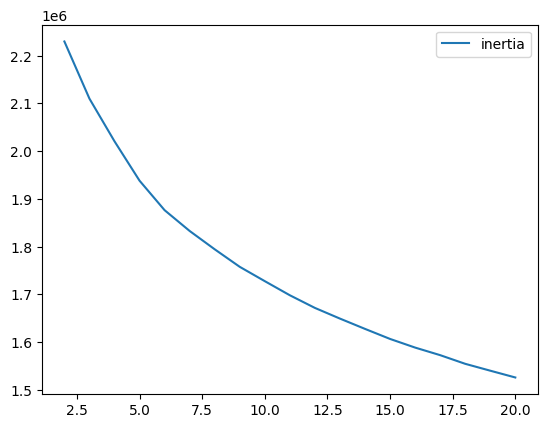

In [14]:
# Plot inertia relative to k # of clusters
kMeans_inertia.plot()

## Accuracy

In [ ]:
# Define analyze cluster function
def analyzeCluster(clusterDF, labelsDF):        # cluster number assigned to each data point and ground truth label for each data point
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']     # Count Points per Cluster
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [16]:
# K-means - Accuracy as the number of clusters varies

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<Axes: >

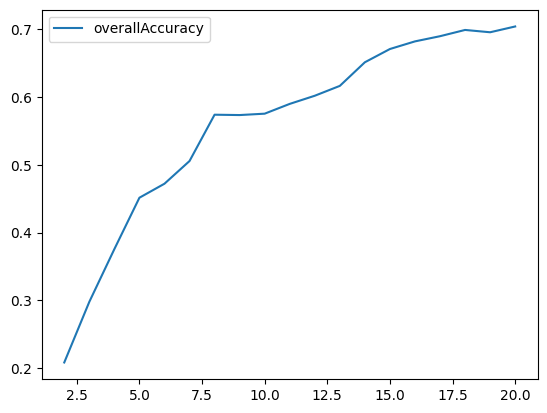

In [17]:
# Plot accuracy
overallAccuracy_kMeansDF.plot()

In [18]:
overallAccuracy_kMeansDF

,overallAccuracy
2,0.20834
3,0.29786
4,0.3757
5,0.45152
6,0.47218
7,0.50566
8,0.57404
9,0.57352
10,0.57556
11,0.59


In [14]:
# Accuracy by cluster
accuracyByLabel_kMeans

0     0.637002
1     0.928903
2     0.848370
3     0.522017
4     0.714490
5     0.950954
6     0.890722
7     0.919121
8     0.404175
9     0.501921
10    0.382313
11    0.587849
12    0.463228
13    0.958022
14    0.870580
15    0.942325
16    0.791050
17    0.843324
18    0.455679
19    0.926480
dtype: float64

In [15]:
# View cluster labels
X_train_kmeansClustered

,cluster
0,4
1,19
2,18
3,2
4,10
...,...
49995,9
49996,13
49997,8
49998,12


In [16]:
# Save cluster labels
X_train_kmeansClustered[0:2000].to_csv(log_dir+'kmeans_cluster_labels.tsv', sep = '\t', index=False, header=False)

## Accuracy as the number of principal components varies

In [17]:
# K-means - Accuracy as the number of components varies

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

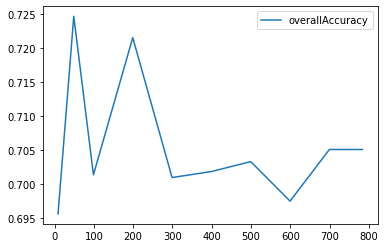

In [18]:
# Accuracy relative to number of principal components
overallAccuracy_kMeansDF.plot()

## Accuracy as the number of original dimensions varies

In [19]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.


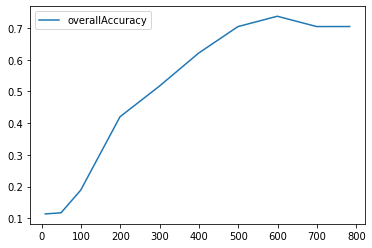

In [20]:
# Accuracy relative to number of original dimensions
overallAccuracy_kMeansDF.plot()

# Hierarchical clustering

In [21]:
# Perform hierarchical clustering
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [22]:
# Show leaves
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562683,2.0
1,28350.0,37674.0,0.590867,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637667,2.0
5,20465.0,24483.0,0.662558,2.0
6,466.0,42098.0,0.664190,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675121,2.0


In [23]:
# Show leaves higher on the tree
Z_dataFrame.iloc[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99965.0,99972.0,161.107035,5197.0
49981,99932.0,99980.0,172.070051,6505.0
49982,99945.0,99960.0,182.840883,3245.0
49983,99964.0,99976.0,184.475756,3683.0
49984,99974.0,99979.0,185.027834,7744.0
49985,99940.0,99975.0,185.345241,5596.0
49986,99957.0,99967.0,211.854765,5957.0
49987,99938.0,99983.0,215.494890,4846.0
49988,99978.0,99984.0,216.760381,11072.0
49989,99970.0,99973.0,217.355917,4899.0


In [24]:
# Create clusters
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [25]:
# Print number of clusters
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [26]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [27]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

In [28]:
# View cluster labels
X_train_hierClustered

,cluster
0,5
1,3
2,15
3,11
4,14
...,...
49995,4
49996,3
49997,6
49998,14


In [29]:
# Save cluster labels
X_train_hierClustered[0:2000].to_csv(log_dir+'hierarchical_cluster_labels.tsv', sep = '\t', index=False, header=False)

# DBSCAN

In [30]:
# Perform DBSCAN
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = \
    pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.242

In [31]:
# Print overall accuracy
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [32]:
# Show cluster results
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
...,...,...
95,43,4
96,83,4
97,11,4
98,54,3


In [33]:
# View cluster labels
X_train_PCA_dbscanClustered

,cluster
0,-1
1,-1
2,-1
3,0
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [34]:
# Save cluster labels
X_train_PCA_dbscanClustered[0:2000].to_csv(log_dir+'dbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

# HDBSCAN

In [35]:
# Perform HDBSCAN
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])

X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

In [36]:
# Print overall accuracy
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.24694


In [37]:
# Show cluster size
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,42569
1,4,5140
2,6,943
3,0,605
4,7,294
5,3,252
6,1,119
7,5,45
8,2,33


In [38]:
# View cluster labels
X_train_PCA_hdbscanClustered

,cluster
0,-1
1,0
2,-1
3,4
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [39]:
# Save cluster labels
X_train_PCA_hdbscanClustered[0:2000].to_csv(log_dir+'hdbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

# Conclusion

In [40]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-05 20:11:58.402559
